In [2]:
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_indexed as npi
from scipy.io import loadmat


from src.ipm import NeuronReader, grablabels, NeuronLoader
from src.metrics import sepind
from src.utils import *

from imblearn.under_sampling import RandomUnderSampler as rus
from scipy.ndimage import gaussian_filter1d as smooth

from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA

In [3]:
fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

In [ ]:
for monkey in ['zebel', 'jenab', 'both']:
    for selectivity in ['fast', 'slow']:
        for statistic in ['dth', 'dpr', 'auc']:
            out_path = f'G:\\Codes\\Processing\\out\\sep\\{monkey.lower()}-{selectivity.lower()}'
            data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

            fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
            sns.despine()

            for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
                so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
                ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
                so = np.transpose(np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0))
                ml = np.transpose(np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0))

                for metric, va in zip([so, ml], ["top", "bottom"]):
                    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=10))
                    anot = metric.mean(1).max()
                    metric /= np.array([so.mean(1), ml.mean(1)]).max()
                    metric -= metric[(data.time > -50) & (data.time <= 0), :].mean()
                    
                    ax.plot(data.time, metric.mean(1), lw=5)
                    ax.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
                    ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
                                xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
                                xycoords='data', fontsize=18, 
                                horizontalalignment='center',
                                verticalalignment=va)
                ax.set_title(region.upper(), fontsize=fontsize)    
                ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
                ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
                ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
                ax.set_xlim(-50, 550)
                ax.set_xlabel('time (ms)', fontsize=fontsize)
                ax.tick_params(axis='both', which='major', labelsize=fontsize)

            
            fig.suptitle("Separation Index, Subtracted by Null Distribution's Mean", fontsize=titlefontsize)
            # axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=fontsize)
            axs[0].set_ylabel(r'$\dfrac{||S_B||_2}{||S_W||_2}$', fontsize=fontsize)


            fig.tight_layout()
            fig.savefig(os.path.join(out_path, "si.eps"), format='eps')
            fig.savefig(os.path.join(out_path, "si.jpg"))

# Visualizing Each Category's Stimulus Set

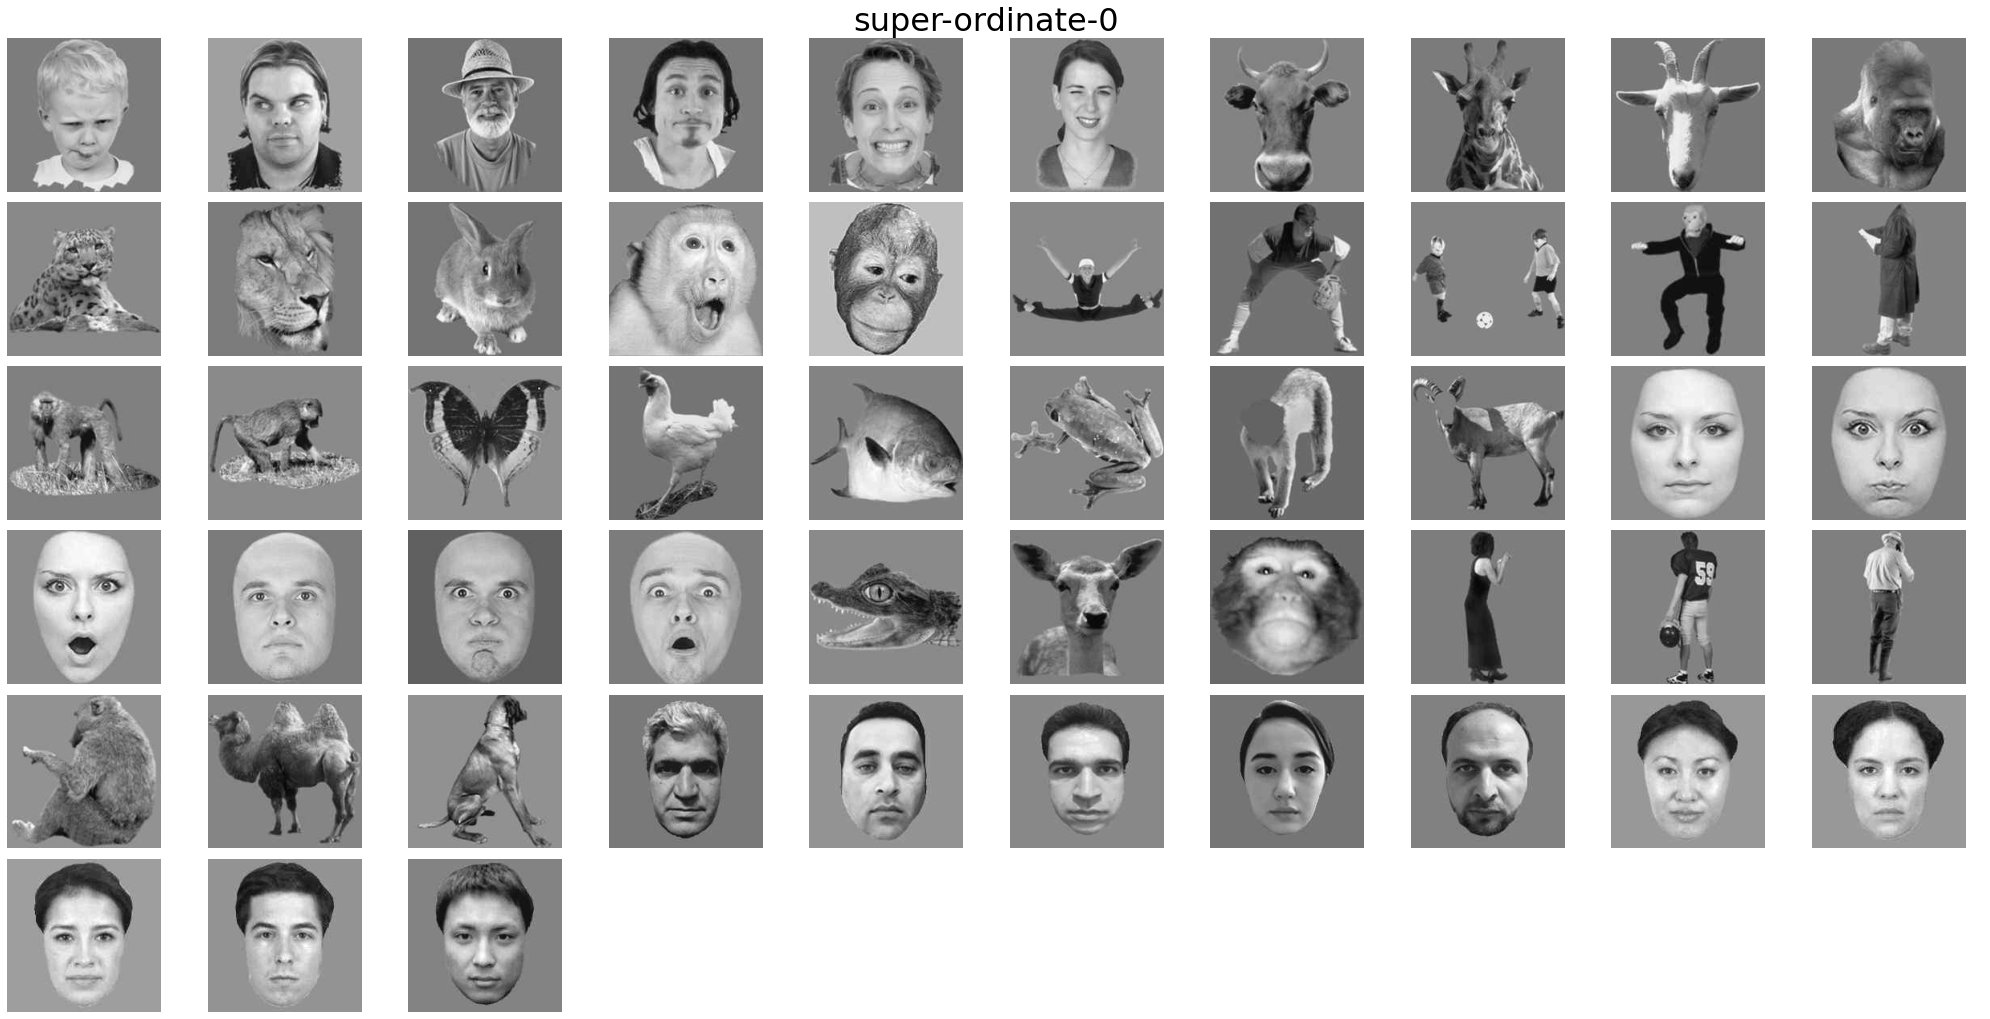

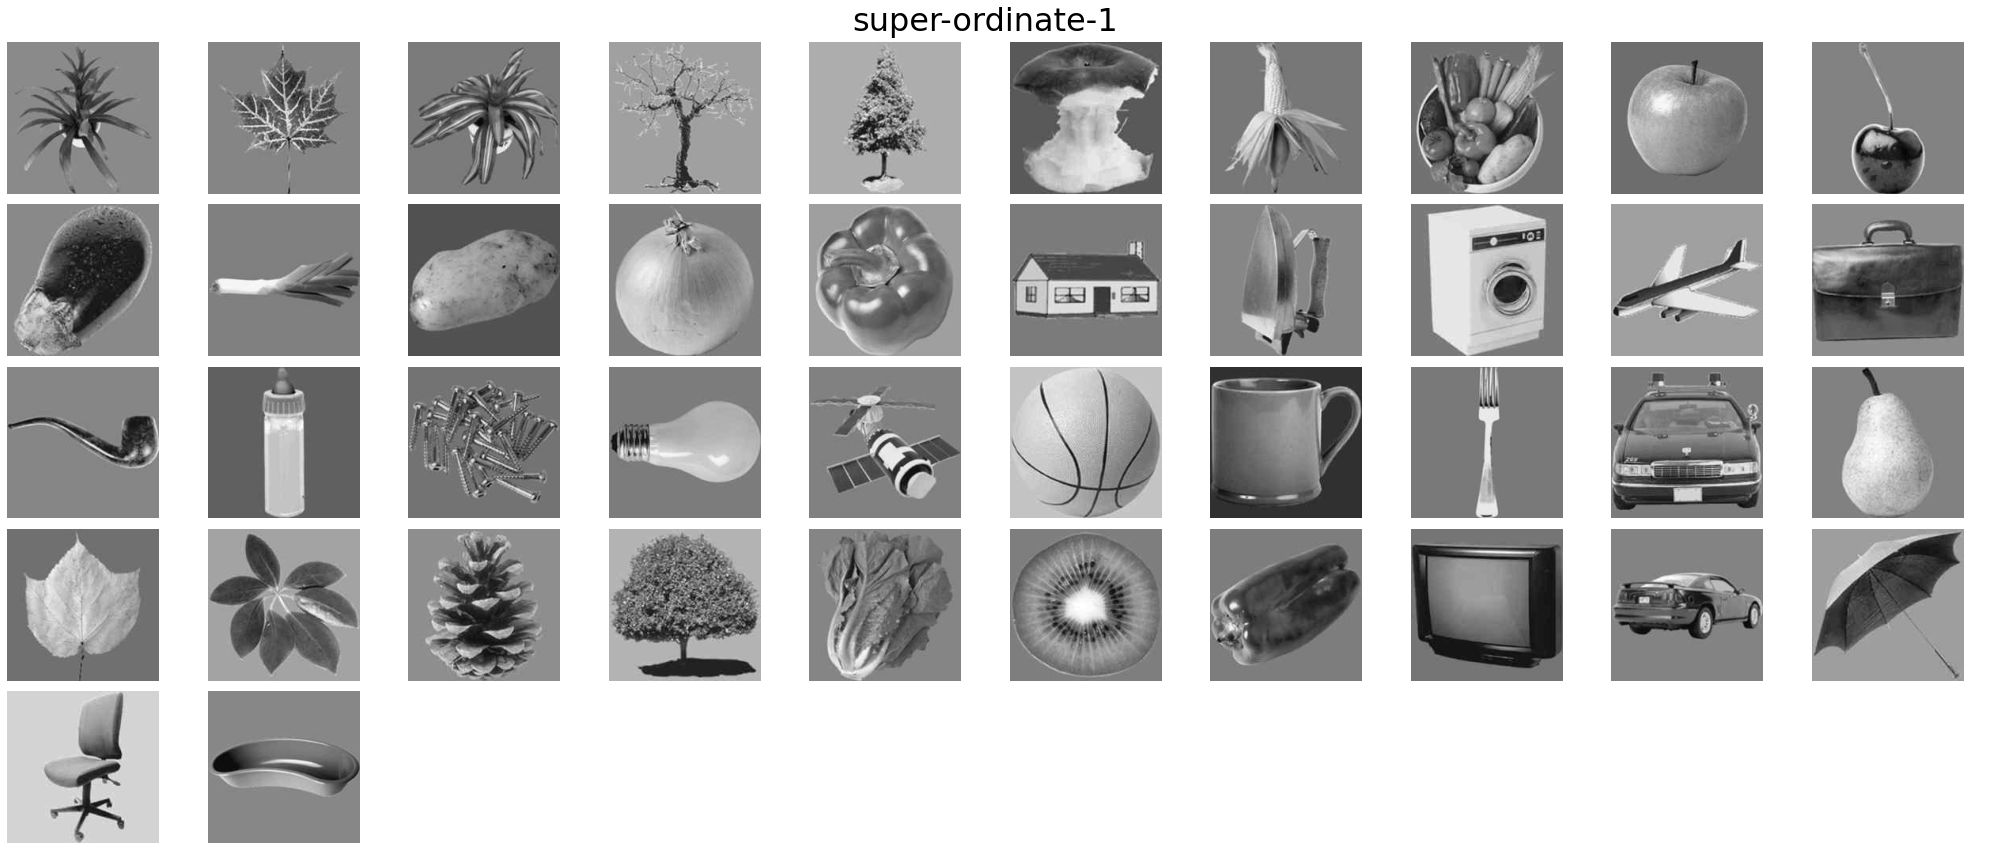

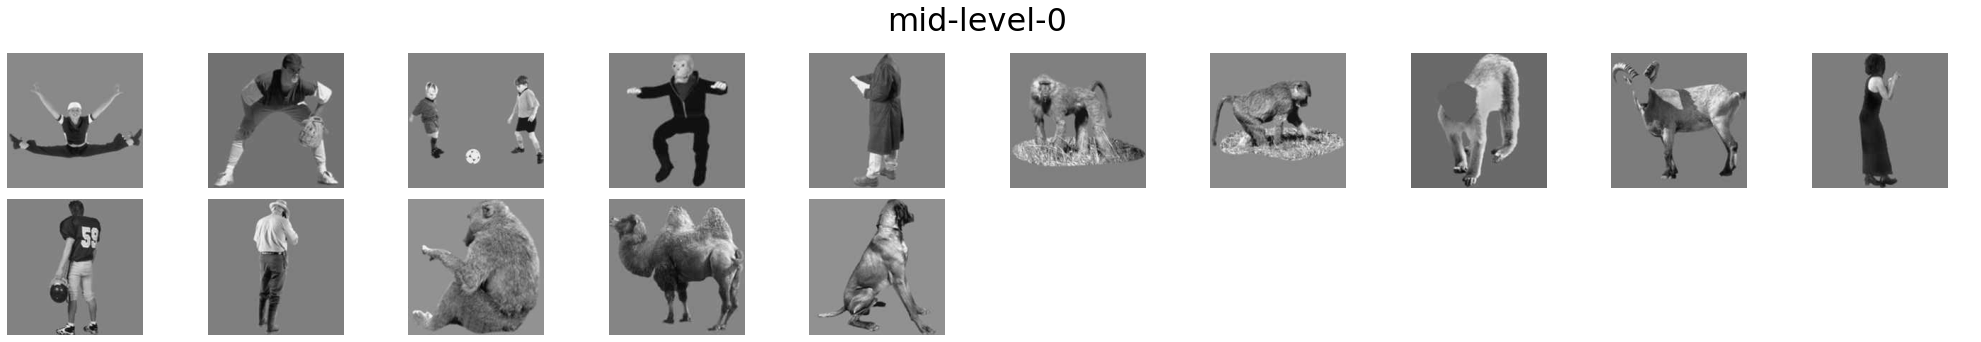

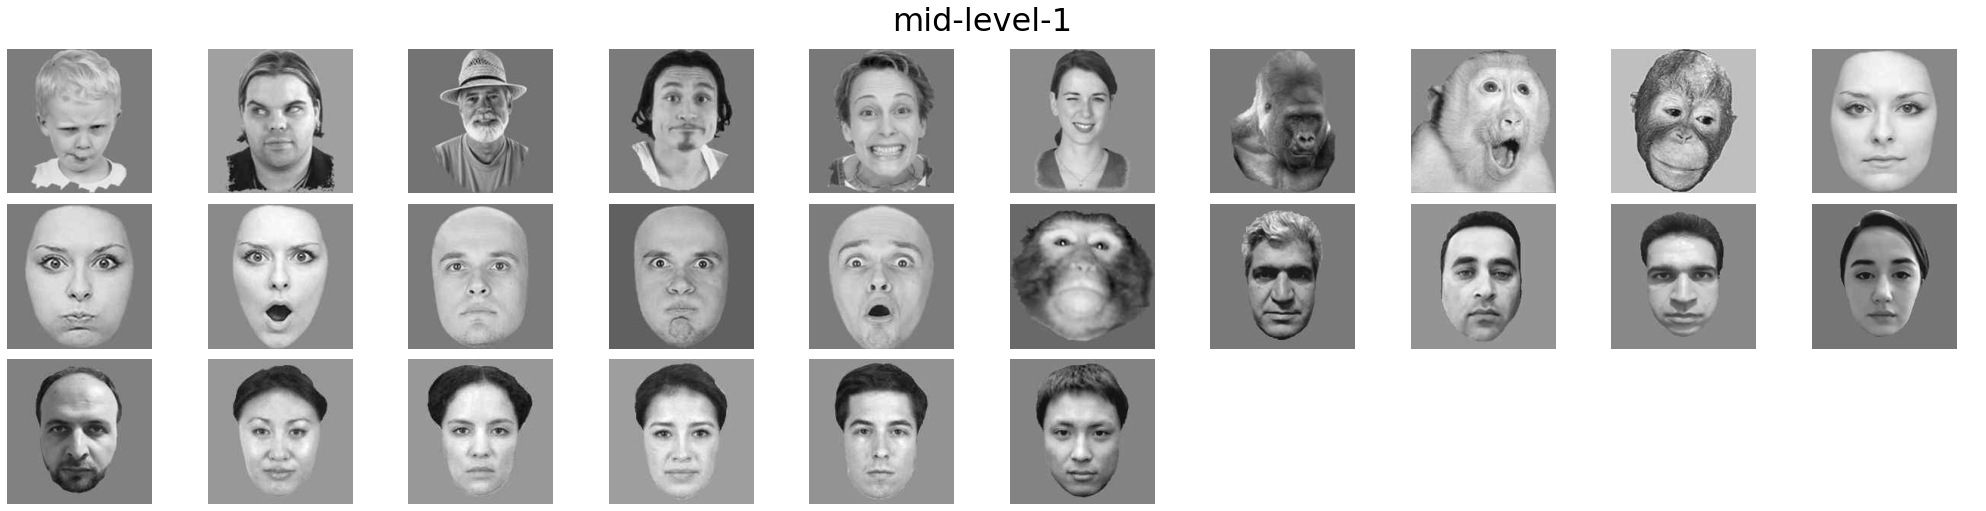

In [10]:
from PIL import Image, ImageOps
stm_path = 'G:/Stimulus'
stm_inst = os.listdir(stm_path)
stm_pics = np.array([np.array(ImageOps.grayscale(Image.open(os.path.join(stm_path, stm)))) for stm in stm_inst])
for categ in ['super-ordinate', 'mid-level']:
    y = grablabels(hierarchy=categ)
    
    for i, imgs in enumerate(npi.group_by(y[np.argwhere(~np.isnan(y))]).split(stm_pics[np.argwhere(~np.isnan(y))])):
        n_col = 10
        n_row = np.ceil(len(imgs) / n_col).astype(np.int8)
        fig, axs = plt.subplots(n_row, n_col, figsize=(28, 24 / n_col * n_row))
        axs = axs.flatten()
        for img, ax in zip(imgs, axs[:imgs.shape[0]]):
            ax.imshow(img[0], cmap='gray')
            ax.set_axis_off()
        for ax in axs[imgs.shape[0]:]:
            ax.set_axis_off()
        fig.suptitle(categ+"-"+str(i), fontsize=32)
        fig.tight_layout()

# Zebel - Slow

In [38]:
class NeuronReader:
    def __init__(self, root, from_file=False):
        self.root = root
        self.sessioninfo = pd.read_csv(os.path.join(root, 'guide.csv'))
        self.from_file = from_file
        self.it = self.load('IT')
        self.pfc = self.load('PFC')
        self.time = np.linspace(-175, 974, self.it.shape[2])

    def load(self, region):
        reg = self.sessioninfo['unit id'].str.split("/").map(lambda x: x[0])
        nunit, nstim = (reg==region.upper()).sum(), 165
        nsample = loadmat(self.sessioninfo['file path'][0])['ua'].shape[1]
        data = np.nan * np.zeros([nstim, nunit, nsample])

        if self.from_file or ~os.path.isfile(os.path.join(self.root, f'{region}.npy')):
            for iunit, fpath in enumerate(self.sessioninfo.loc[reg==region.upper()]['file path']):
                ua = loadmat(fpath)['ua']
                cm = loadmat(os.path.join(os.path.dirname(fpath), 'cm.mat'))['cm']
                if cm.size > ua.shape[0]:
                    cm = cm[:ua.shape[0]]
                for istim in np.arange(1, nstim + 1, 1):
                    data[istim-1, iunit, :] = ua[(cm == istim).squeeze(), :].mean(0)
            out = self.movavg(data, 50, 1)
            np.save(os.path.join(self.root, f'{region}.npy'), out)
        else:
            out = np.load(os.path.join(self.root, f'{region}.npy'))
        return out
    
    def movavg(self, inp, bl, ss):
        nbin = int(np.floor((inp.shape[2] - bl) / ss))
        out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
        for ibin in range(nbin):
            out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
        return out
    
data = NeuronReader(f'G:/Data/Slow/Zebel')

In [40]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=True)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=True)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [10]:
monkey = "zebel"
selectivity = "slow"

out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nrm_order = 2
nmb_rep = 200

In [12]:
data = NeuronLoader(f'G:/Data/Slow/Zebel')

In [48]:
nmb_component = .95

for region in ['it', 'pfc']:
    region_data = data.it if region == 'it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']:
        metric_si, metric_ci = [], []
        y_ = grablabels(hierarchy=categ)
        nmb_sample = np.min([(y_==0).sum(), (y_==1).sum()])
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci.npy'), metric_ci)

        metric_si, metric_ci = [], []
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                np.random.seed(iboot)
                np.random.shuffle(y)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-null.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci-null.npy'), metric_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

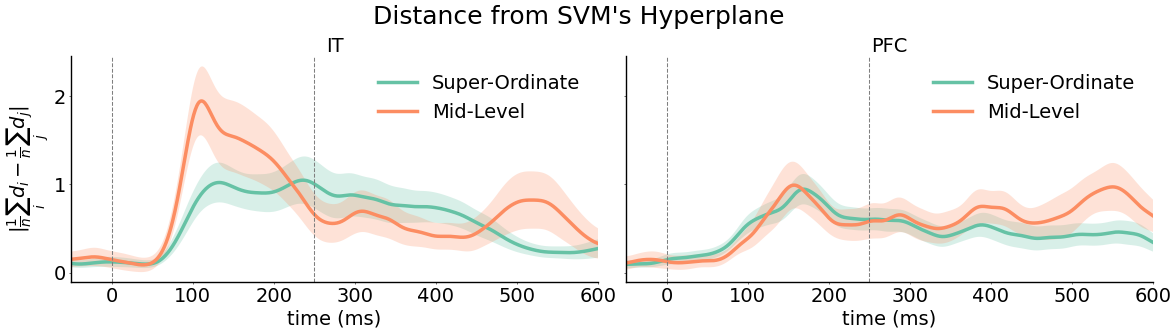

In [97]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()
data.time = np.linspace(-175, 974, data.it.shape[2])

for iregion, region in enumerate(["it", "pfc"]):
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)

    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

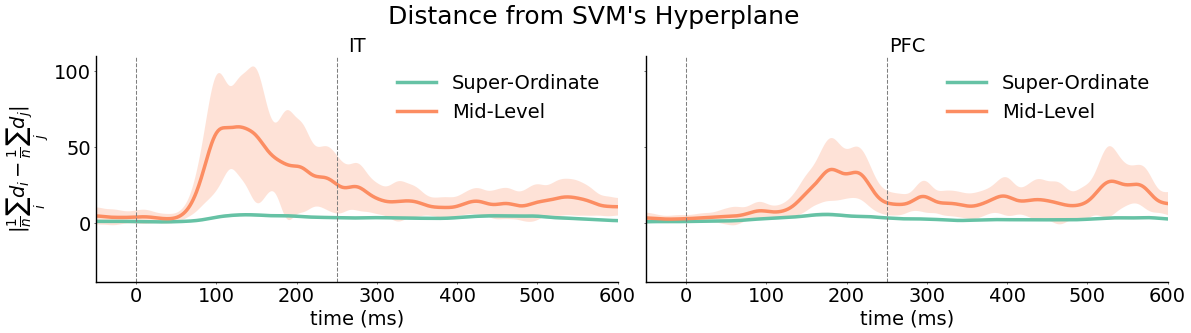

In [13]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()
data.time = np.linspace(-175, 974, data.it.shape[2])

for iregion, region in enumerate(["it", "pfc"]):
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-ci-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-ci-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate-ci.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level-ci.npy')) - ml0.mean(0)

    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"cat.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"cat.jpg"), dpi=600, bbox_inches='tight')

# Jenab - Slow

In [14]:
from src.ipm import NeuronReader

monkey = "jenab"
selectivity = "slow"

# data = NeuronReader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}', from_file=True)
data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200

In [55]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=True)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=True)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [58]:
nmb_component = .95

for region in ['it', 'pfc']:
    region_data = data.it if region == 'it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']:
        metric_si, metric_ci = [], []
        y_ = grablabels(hierarchy=categ)
        nmb_sample = np.min([(y_==0).sum(), (y_==1).sum()])
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci.npy'), metric_ci)

        metric_si, metric_ci = [], []
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                np.random.seed(iboot)
                np.random.shuffle(y)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-null.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci-null.npy'), metric_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

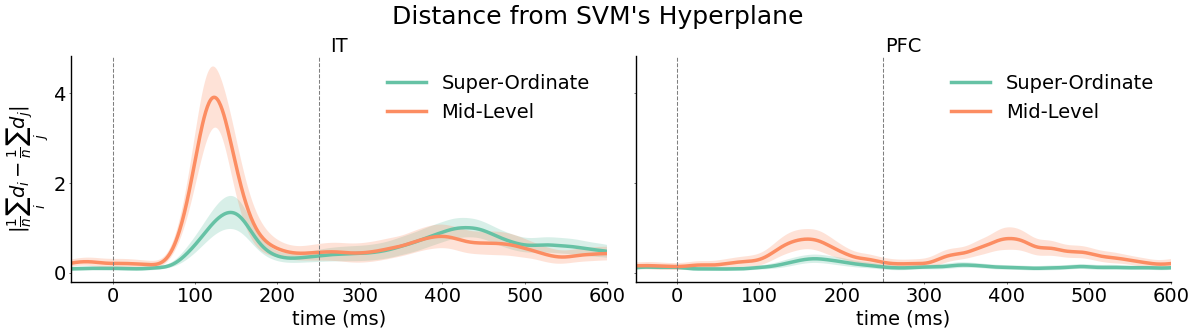

In [99]:
data.time = np.linspace(-175, 974, data.it.shape[2])

fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):
    # ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dth.npy'))
    # so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'))
    
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
    # soo = np.load(os.path.join(out_path, region+'-super-ordinate.npy'))
    # mll = np.load(os.path.join(out_path, region+'-mid-level.npy'))
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    # ax.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

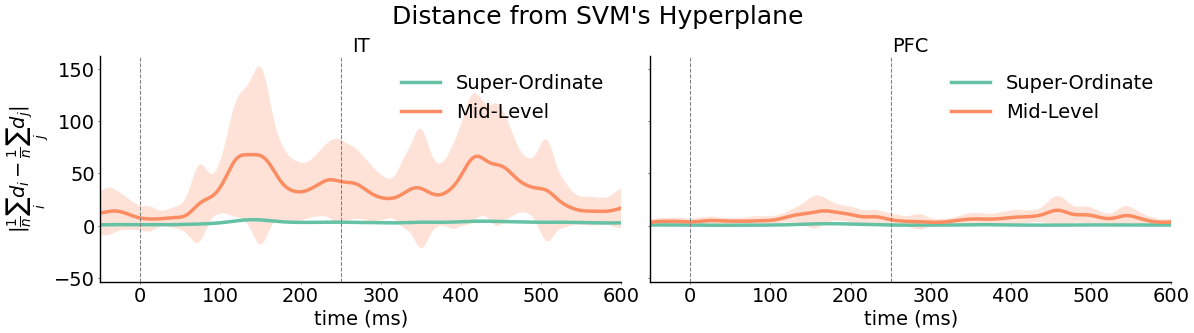

In [15]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()
data.time = np.linspace(-175, 974, data.it.shape[2])

for iregion, region in enumerate(["it", "pfc"]):
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-ci-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-ci-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate-ci.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level-ci.npy')) - ml0.mean(0)

    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"cat.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"cat.jpg"), dpi=600, bbox_inches='tight')

# Both - Slow

In [15]:
from src.ipm import NeuronLoader
data = NeuronLoader(r'G:\Data\Slow\Both')

In [16]:
monkey = "both"
selectivity = "slow"

out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200
nrm_order = 2

In [17]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=True)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=True)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [18]:
for region in ['it', 'pfc']:
    region_data = data.it if region == 'it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']:
        metric_si, metric_ci = [], []
        y_ = grablabels(hierarchy=categ)
        nmb_sample = np.min([(y_==0).sum(), (y_==1).sum()])
        for iboot in (pbar := tqdm(range(nmb_rep))):
            pbar.set_description(monkey+"-"+selectivity+"-"+region+"-"+categ)
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci.npy'), metric_ci)

        metric_si, metric_ci = [], []
        for iboot in (pbar := tqdm(range(nmb_rep))):
            pbar.set_description(monkey+"-"+selectivity+"-"+region+"-"+categ+"null")
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                np.random.seed(iboot)
                np.random.shuffle(y)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-null.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci-null.npy'), metric_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [42]:
out_path = 'G:\\Codes\\Processing\\out\\sep\\both-fast'
data.time = np.linspace(-175, 674, 850)

In [40]:
data.time.shape

(850,)

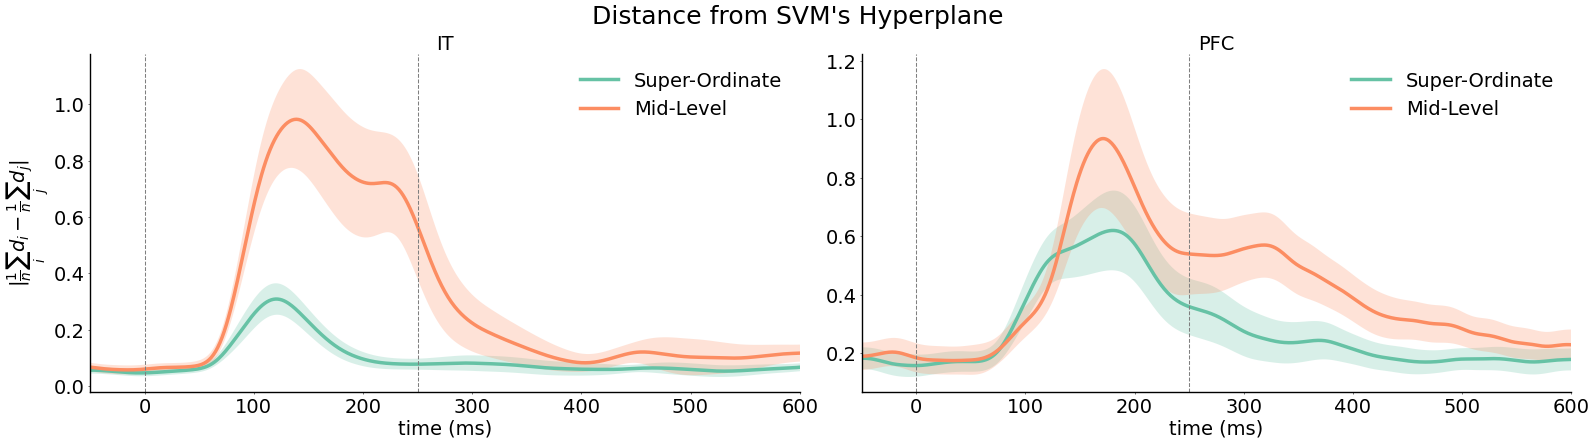

In [41]:
# data.time = np.linspace(-175, 974, data.it.shape[2])

fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):   
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        metric /= np.array([so.mean(0), ml.mean(0)]).max()
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_') 
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
# plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
# plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

# Zebel - Fast

In [21]:
from src.ipm import NeuronLoader

monkey = "zebel"
selectivity = "fast"

data = NeuronLoader(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}")
out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200
nrm_order = 2

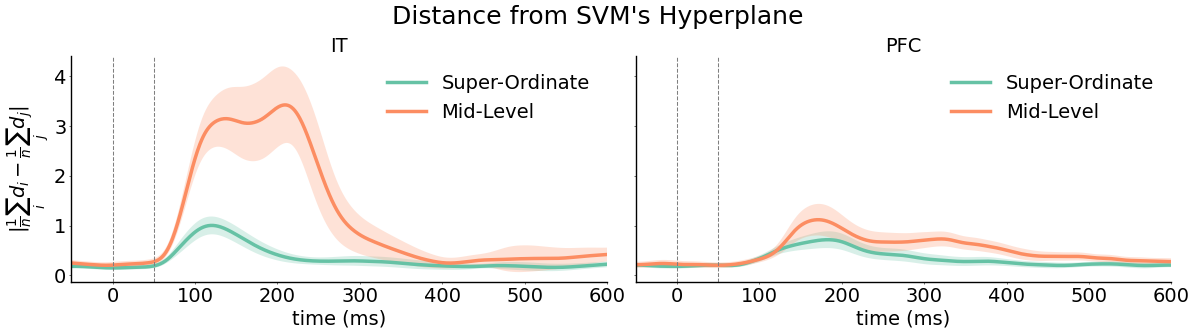

In [22]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):   
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_') 
    ax.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

# Jenab - Fast

In [8]:
from src.ipm import NeuronLoader

monkey = "jenab"
selectivity = "fast"

data = NeuronLoader(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}")
out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200
nrm_order = 2

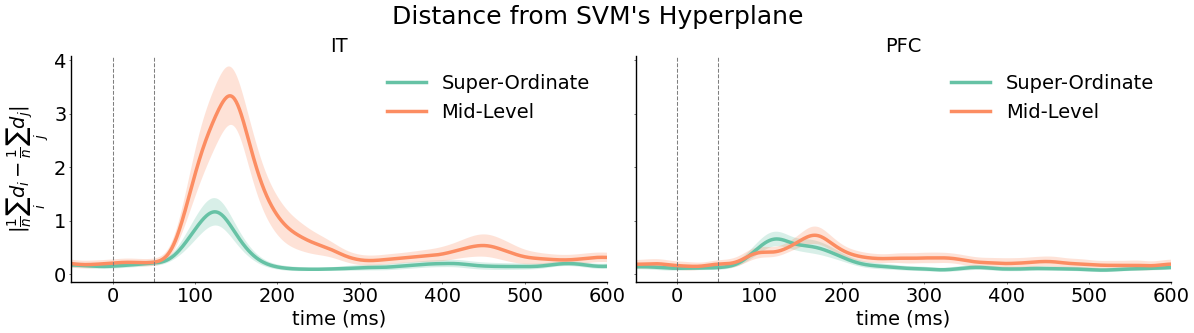

In [20]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):   
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_') 
    ax.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

# Both - Fast

In [23]:
data_z = NeuronReader(f"G:/Data/Fast/Zebel")
data_j = NeuronReader(f"G:/Data/Fast/Jenab")

In [24]:
import copy
data = copy.deepcopy(data_z)
data.it = np.concatenate([data.it, data_j.it], axis=1)
data.pfc = np.concatenate([data.pfc, data_j.pfc], axis=1)

In [25]:
np.save("G:\Data\Fast\Both\IT.npy", data.it)
np.save("G:\Data\Fast\Both\PFC.npy", data.pfc)

In [3]:
from src.ipm import NeuronLoader

monkey = "both"
selectivity = "fast"

data = NeuronLoader(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}")
out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200
nrm_order = 2

In [7]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=True)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=True)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [8]:
for region in ['it', 'pfc']:
    region_data = data.it if region == 'it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']:
        metric_si, metric_ci = [], []
        y_ = grablabels(hierarchy=categ)
        nmb_sample = np.min([(y_==0).sum(), (y_==1).sum()])
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci.npy'), metric_ci)

        metric_si, metric_ci = [], []
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                np.random.seed(iboot)
                np.random.shuffle(y)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-null.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci-null.npy'), metric_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

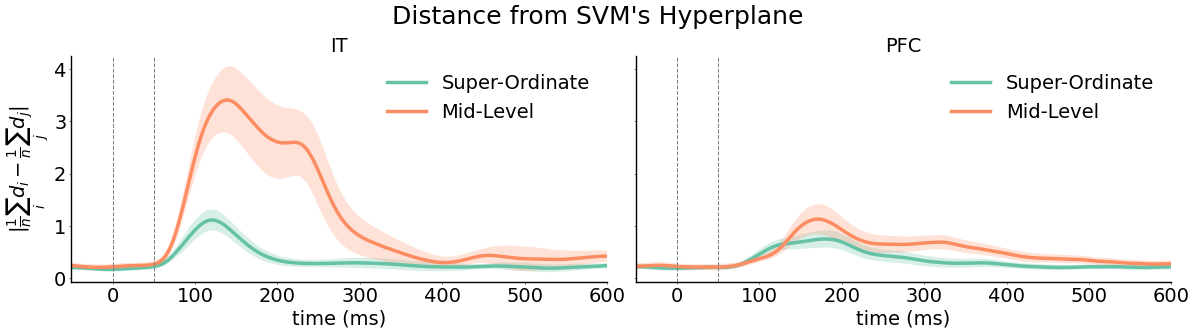

In [9]:
fig, axs = plt.subplots(1, 2, figsize=np.array([24, 6.75]), dpi=50, sharey=True)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):   
    so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
    ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
    so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
    ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(metric, sigma=10))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax, region in zip(axs, ['it', 'pfc']):
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_') 
    ax.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 600)
    ax.set_title(f'{region.upper()}', fontsize=fontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);
axs[0].set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
fig.suptitle(f'Distance from SVM\'s Hyperplane', fontsize=titlefontsize)

fig.tight_layout()
plt.savefig(os.path.join(out_path, f"sep.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(out_path, f"sep.jpg"), dpi=600, bbox_inches='tight')

# Calculating Separability Index

In [9]:
monkey = "jenab"
selectivity = "fast"

data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
out_path  = f'G:\\Codes\\Processing\\out\\sep\\{monkey}-{selectivity}'
# nmb_component = 20
nrm_order = 2
nmb_rep = 200

In [11]:
data = NeuronLoader(data_path)

In [12]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=True)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=True)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

## Different Ordinations

### Estimation

In [13]:
nmb_component = .95

nmb_rep = 200

for region in ['it', 'pfc']:
    region_data = data.it if region == 'it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']:
        metric_si, metric_ci = [], []
        y_ = grablabels(hierarchy=categ)
        nmb_sample = np.min([(y_==0).sum(), (y_==1).sum()])
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci.npy'), metric_ci)

        metric_si, metric_ci = [], []
        for iboot in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, y_, nmb_sample, seed=iboot)
            si, ci = [], []
            for bin in range(region_data.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=iboot)
                np.random.seed(iboot)
                np.random.shuffle(y)
                Xr = pca.fit_transform(X[:,:,bin])

                s_total = EmpiricalCovariance().fit(Xr).covariance_ * Xr.shape[0]
                s_within = np.zeros_like(s_total)
                for group in npi.group_by(y).split(Xr):
                    s_within += EmpiricalCovariance().fit(group).covariance_ * group.shape[0]
                s_between = s_total - s_within
                si.append(np.linalg.norm(s_between, nrm_order) / np.linalg.norm(s_within, nrm_order))
                ci.append(np.trace(np.linalg.pinv(s_within) @ s_between))
            metric_si.append(si)
            metric_ci.append(ci)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-null.npy'), metric_si)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-ci-null.npy'), metric_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### Visualization

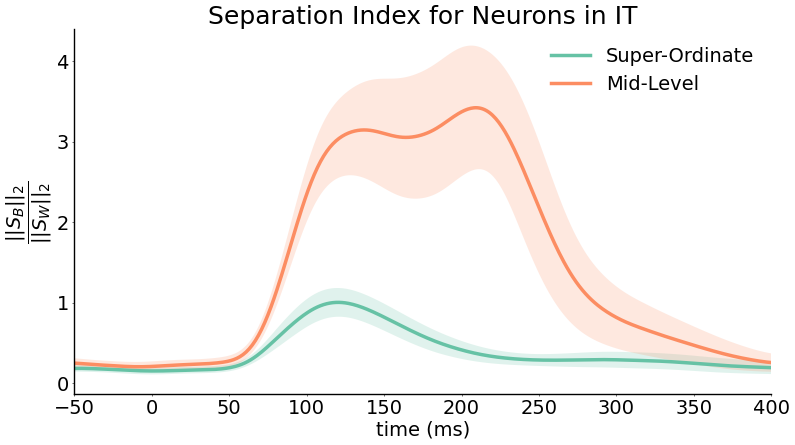

In [13]:
fontsize = 28
titlefontsize = 36
make_smooth = True 
region = 'it'

sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

so0 = np.load(os.path.join(out_path, region+'-super-ordinate-null.npy'))
ml0 = np.load(os.path.join(out_path, region+'-mid-level-null.npy'))
so = np.load(os.path.join(out_path, region+'-super-ordinate.npy')) - so0.mean(0)
ml = np.load(os.path.join(out_path, region+'-mid-level.npy')) - ml0.mean(0)
soo = np.load(os.path.join(out_path, region+'-super-ordinate.npy'))
mll = np.load(os.path.join(out_path, region+'-mid-level.npy'))

for si in [so, ml]:
    si = si if not make_smooth else smooth(si, sigma=10)
    # si /= si.max()
    plt.plot(data.time, si.mean(0), lw=5)
    plt.fill_between(data.time, si.mean(0) + si.std(0), si.mean(0) - si.std(0), 
                     alpha=.2, label='_nolegend_')

sns.despine()
axs.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Separation Index for Neurons in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$\dfrac{||S_B||_2}{||S_W||_2}$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2)


fig.tight_layout()
plt.savefig(os.path.join(out_path, f"{region.lower()}.png"), dpi=600, bbox_inches='tight')
# plt.savefig("separability-time-series-it-smoothed.png", dpi=600, bbox_inches='tight')

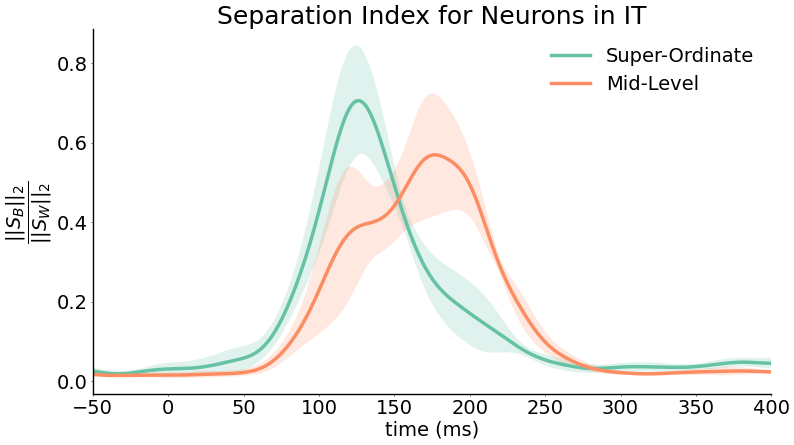

In [74]:
fontsize = 28
titlefontsize = 36
make_smooth = True 

sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

so0 = np.load(os.path.join(out_path, 'it-super-ordinate-ci-null.npy'))
ml0 = np.load(os.path.join(out_path, 'it-mid-level-ci-null.npy'))
# so = (np.load(os.path.join(out_path, 'it-super-ordinate-ci.npy')) - so0.mean(0)) #/ so0.std(0)
# ml = (np.load(os.path.join(out_path, 'it-mid-level-ci.npy')) - ml0.mean(0)) #/ ml0.std(0)
so = np.load(os.path.join(out_path, 'it-super-ordinate-ci.npy'))
ml = np.load(os.path.join(out_path, 'it-mid-level-ci.npy'))

for si in [so, ml]:
    si /= si.max()
    si = si if not make_smooth else smooth(si, sigma=10)
    plt.plot(data.time, si.mean(0), lw=5)
    plt.fill_between(data.time, si.mean(0) + si.std(0), si.mean(0) - si.std(0), 
                     alpha=.2, label='_nolegend_')

sns.despine()
axs.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Separation Index for Neurons in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$\dfrac{||S_B||_2}{||S_W||_2}$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2)


fig.tight_layout()
plt.savefig(os.path.join(out_path, "categorization-time-series-it.png"), dpi=600, bbox_inches='tight')
# plt.savefig("separability-time-series-it-smoothed.png", dpi=600, bbox_inches='tight')

In [72]:
si.shape

(5, 850)